In [542]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn

from preprocess._utils import *
import torch.optim as optimizer
from torch.autograd import Variable
from models._main import *
from preprocess._utils import *
import torch.nn as nn
import torch.utils.data as Data
from train._main import *
from data._utils import *
from models._utils import *

In [543]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


## Hyperparameters

In [544]:
time_step = 3
num_neurons = 302
used_neurons = 302
INPUT_SIZE = num_neurons
HIDDEN_SIZE = 100
BATCH_SIZE = 128
EPOCH = 10000
LR = 0.1  # learning rate
DROP_RATE = 0.2  # drop out
LAYERS = 2  # hidden layer
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [545]:
class lstm(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE):
        super(lstm, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
            dropout=DROP_RATE,
            batch_first=True,
            # bidirectional=True,
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        # print(r_out.shape)
        # print(r_out[:, :, -1:].shape)
        output = self.hidden_out(r_out)
        # print(output.shape)
        return output

## Data Preprocess

In [546]:
#!/usr/bin/env python
# encoding: utf-8

def create_synthetic_data(d, n, ifnoise=False):
    res = np.zeros((d, n))
    assert isinstance(n, int), "wrong number for samples"
    der = []
    for i in range(0, n):
        freq = np.random.uniform(1.0 / d, 5 * 1.0 / d)
        phi = np.random.random()
        step = np.arange(d)
        res[:, i] = np.sin(2 * np.pi * freq * step + phi * (np.pi / 180))
        der.append(2 * np.pi * freq)

    return res, der


def create_dataset(raw_data, raw_der):
    sine_dataset = dict()
    for i, real_data in enumerate(raw_data):
        worm = "worm" + str(i)
        max_time = seq_len
        num_neurons = num_signal
        der = np.array(raw_der[i])
        der = der.reshape(der.shape[0], 1).T
        time_in_seconds = torch.tensor(np.array(np.arange(seq_len)).reshape(seq_len, 1))
        dt = torch.tensor(der)

        num_named = num_neurons
        real_data = torch.tensor(
            real_data, dtype=torch.float64
        )

        smooth_real_data, residual, smooth_residual = smooth_data_preprocess(real_data, "fft")

        for i in range(residual.shape[1]):
            residual[:, i] = residual[:, i] / dt[:, i]

        sine_dataset.update(
            {
                worm: {
                    "dataset": "sine",
                    "worm": worm,
                    "calcium_data": real_data,
                    "smooth_calcium_data": smooth_real_data,
                    "residual_calcium": residual,
                    "residual_smooth_calcium": smooth_residual,
                    "neuron_to_idx": range(0, num_neurons),
                    "idx_to_neuron": range(num_neurons - 1, -1, -1),
                    "max_time": int(max_time),
                    "time_in_seconds": time_in_seconds,
                    "dt": dt,
                    "named_neurons_mask": torch.full((num_neurons,), True),
                    "named_neuron_to_idx": range(0, num_neurons),
                    "idx_to_named_neuron": range(num_neurons - 1, -1, -1),
                    "num_neurons": int(num_neurons),
                    "num_named_neurons": num_named,
                    "num_unknown_neurons": int(num_neurons) - num_named,
                },
            }
        )
    return sine_dataset



## DataLoader

In [547]:
seq_len = 3312
num_signal = 302
if_noise = False
num_worms = 6
raw_data = []
raw_der = []
for j in range(num_worms):
    x, der = create_synthetic_data(seq_len, num_signal, if_noise)
    x_torch = Variable(torch.from_numpy(x), requires_grad=False)
    raw_data.append(x_torch)
    raw_der.append(der)

dataset = create_dataset(raw_data, raw_der)

/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_11630/843486066.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(


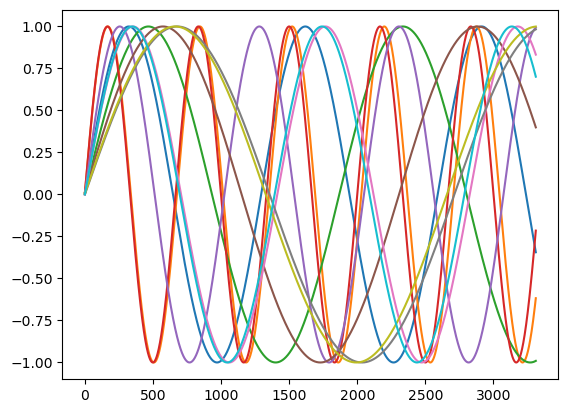

In [548]:
plt.plot(dataset["worm0"]["calcium_data"][:, 0:10])
# plt.plot(dataset["worm0"]["residual_calcium"][:, 0])
plt.show()

In [549]:
dataset = get_dataset(OmegaConf.load("../conf/dataset.yaml"))

worm = "worm0"
cutdown = 3312
cutneuron = num_neurons
calcium_data = dataset[worm]["calcium_data"][:cutdown, :cutneuron].to(torch.float32)
residual_calcium = dataset[worm]["residual_calcium"][:cutdown, :cutneuron].to(torch.float32)

mask = torch.full([1, calcium_data.shape[1]], True)
# for i in range(used_neurons):
#     mask[:, i] = True


# train and test
train_size = int(0.8 * cutdown)
test_size = cutdown - train_size

train_ca, test_ca = calcium_data.split(train_size, dim=0)
train_res, test_res = residual_calcium.split(train_size, dim=0)

print(calcium_data.shape)

Chosen dataset(s): ['Uzel2022']
Num. worms: 6
Worm names: ['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5']


torch.Size([3312, 302])


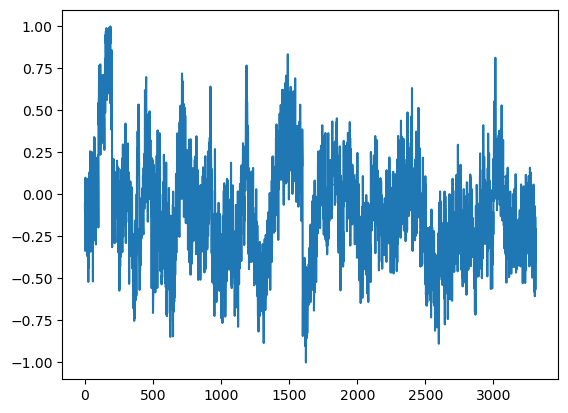

In [550]:
plt.plot(calcium_data[:, 0])
plt.show()

In [551]:
train_loop_cal = []
train_loop_res = []
for i in range(0, train_ca.shape[0] - time_step):
    train_loop_res.append(np.array(train_res[i:i + time_step, :]))
    train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

train_loop_cal = torch.tensor(np.array(train_loop_cal))
train_loop_res = torch.tensor(np.array(train_loop_res))

# print(train_loop_cal.shape, train_loop_res.shape)

test_loop_cal = []
test_loop_res = []
for i in range(0, test_ca.shape[0] - time_step):
    test_loop_res.append(np.array(test_res[i:i + time_step, :]))
    test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

test_loop_cal = torch.tensor(np.array(test_loop_cal))
test_loop_res = torch.tensor(np.array(test_loop_res))


In [552]:
print(train_loop_cal.shape)
print(calcium_data.shape)

torch.Size([2646, 3, 302])
torch.Size([3312, 302])


In [553]:
train_loop_cal_target = torch.zeros_like(train_loop_cal)
train_loop_cal_target[:-1] = train_loop_cal[1:]

test_loop_cal_target = torch.zeros_like(test_loop_cal)
test_loop_cal_target[:-1] = test_loop_cal[1:]


train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_cal_target)
test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_cal_target)


train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [554]:
model = lstm(INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss(reduction="mean")
print(model)

lstm(
  (rnn): LSTM(302, 100, num_layers=2, batch_first=True, dropout=0.2)
  (hidden_out): Linear(in_features=100, out_features=302, bias=True)
)


In [555]:
print(calcium_data.shape)

torch.Size([3312, 302])


# Code from Project


train code from project

In [ ]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            mask_train = mask
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            # print(Y_train.shape, mask.shape)
            mask_train = mask_train.repeat(Y_train.shape[1], 1)
            mask_train = mask_train.unsqueeze(0)
            mask_train = mask_train.repeat(Y_train.shape[0], 1, 1)
            # print(Y_train.shape, mask.shape)
            base = criterion(torch.zeros_like(Y_train*mask_train), Y_train*mask_train)
            # print(Y_train*mask, (Y_train*mask).shape)
            # print(X_train.shape)
            Y_tr = model(X_train) # .transpose(1, 2))  # Forward pass.
            Y_tr = Y_tr # .transpose(1, 2)
            loss = criterion(Y_tr*mask_train, Y_train*mask_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            mask_test = mask
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            mask_test = mask_test.repeat(Y_test.shape[1], 1)
            mask_test = mask_test.unsqueeze(0)
            mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test*mask_test), Y_test*mask_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test) #.transpose(1, 2))  # Forward pass.
            Y_pred = Y_pred # .transpose(1, 2)
            loss = criterion(Y_pred*mask_test, Y_test*mask_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,train_pred_loss_history[-1]-train_base_loss_history[-1],test_pred_loss_history[-1]-test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()



Start Training!
--------worm No. 0--------


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_11630/3686776303.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_11630/3686776303.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)


epoch = 0, train_loss = -0.0004, test_loss = 0.0007
epoch = 1, train_loss = -0.0024, test_loss = -0.0012
epoch = 2, train_loss = -0.0043, test_loss = -0.0032
epoch = 3, train_loss = -0.0061, test_loss = -0.0051
epoch = 4, train_loss = -0.0079, test_loss = -0.0068
epoch = 5, train_loss = -0.0096, test_loss = -0.0086
epoch = 6, train_loss = -0.0112, test_loss = -0.0103
epoch = 7, train_loss = -0.0128, test_loss = -0.0118
epoch = 8, train_loss = -0.0144, test_loss = -0.0135
epoch = 9, train_loss = -0.0159, test_loss = -0.0149
epoch = 10, train_loss = -0.0174, test_loss = -0.0166
epoch = 11, train_loss = -0.0188, test_loss = -0.0181
epoch = 12, train_loss = -0.0202, test_loss = -0.0193
epoch = 13, train_loss = -0.0215, test_loss = -0.0207
epoch = 14, train_loss = -0.0228, test_loss = -0.0223
epoch = 15, train_loss = -0.0241, test_loss = -0.0233
epoch = 16, train_loss = -0.0253, test_loss = -0.0247
epoch = 17, train_loss = -0.0265, test_loss = -0.0258
epoch = 18, train_loss = -0.0277, test_

In [ ]:
print(INPUT_SIZE, HIDDEN_SIZE)
print(time_step)
print(calcium_data.shape)

In [ ]:
# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []

print(calcium_data.shape[1])

for i in range(time_step, calcium_data.shape[0]-1):
    X, Y = calcium_data[i-time_step:i, :num_neurons], calcium_data[i-time_step+1:i+1, :num_neurons]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(np.array(X_test))
Y_test = torch.tensor(np.array(Y_test))
print(X_test.shape)
optimizer.zero_grad()  # Clear gradients.
mask_test = mask
mask_test = mask_test.repeat(Y_test.shape[1], 1)
mask_test = mask_test.unsqueeze(0)
mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
# Baseline: loss if the model predicted the residual to be 0
base = criterion(torch.zeros_like(Y_test*mask_test), Y_test*mask_test)
# X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
Y_pred = model(X_test) # .transpose(1, 2))  # Forward pass.
print(X_test.shape)
Y_pred = Y_pred # .transpose(1, 2)
print(Y_pred.shape, Y_test.shape)

# [batch, time_step, neuron]
plt.plot(Y_test.detach().numpy()[:, 0, 0])
plt.plot(Y_pred.detach().numpy()[:, 0, 0])
plt.legend(["target", "pred"])
plt.show()

# Local Version of Code


not pushed

In [ ]:

worm = "worm0"
cutdown = 3312
cutneuron = 302
calcium_data = dataset[worm]["calcium_data"][:cutdown, :cutneuron].to(torch.float32)
residual_calcium = dataset[worm]["residual_calcium"][:cutdown, :cutneuron].to(torch.float32)

mask = torch.full([1, calcium_data.shape[1]], False)
for i in range(used_neurons):
    mask[:, i] = True


# train and test
train_size = int(0.8 * cutdown)
test_size = cutdown - train_size

train_ca, test_ca = calcium_data.split(train_size, dim=0)
train_res, test_res = residual_calcium.split(train_size, dim=0)

print(train_ca.shape)

In [ ]:
train_loop_cal = []
train_loop_res = []
for i in range(0, train_ca.shape[0] - time_step):
    train_loop_res.append(np.array(train_res[i:i + time_step, :]))
    train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

train_loop_cal = torch.tensor(np.array(train_loop_cal))
train_loop_res = torch.tensor(np.array(train_loop_res))

# print(train_loop_cal.shape, train_loop_res.shape)

test_loop_cal = []
test_loop_res = []
for i in range(0, test_ca.shape[0] - time_step):
    test_loop_res.append(np.array(test_res[i:i + time_step, :]))
    test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

test_loop_cal = torch.tensor(np.array(test_loop_cal))
test_loop_res = torch.tensor(np.array(test_loop_res))


In [ ]:
train_loop_cal_target = torch.zeros_like(train_loop_cal)
train_loop_cal_target[:-1] = train_loop_cal[1:]

test_loop_cal_target = torch.zeros_like(test_loop_cal)
test_loop_cal_target[:-1] = test_loop_cal[1:]


train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_res)
test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_res)


train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [ ]:
model = lstm(INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss(reduction="mean")
print(model)
print(calcium_data.shape)

In [ ]:


print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            mask_train = mask
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0

            base = criterion(Y_train, Y_train)
            # print(Y_train*mask, (Y_train*mask).shape)
            # print(X_train.shape)
            Y_tr = model(X_train) # .transpose(1, 2))  # Forward pass.
            Y_tr = Y_tr # .transpose(1, 2)
            loss = criterion(Y_tr, Y_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(Y_test, Y_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test) #.transpose(1, 2))  # Forward pass.
            Y_pred = Y_pred # .transpose(1, 2)
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,train_pred_loss_history[-1]-train_base_loss_history[-1],test_pred_loss_history[-1]-test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()

In [ ]:
# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []

print(calcium_data.shape[1])

for i in range(time_step, calcium_data.shape[0]-1):
    X, Y = calcium_data[i-time_step:i, :num_neurons], residual_calcium[i-time_step+1:i+1, :num_neurons]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(np.array(X_test))
Y_test = torch.tensor(np.array(Y_test))
print(X_test.shape)
optimizer.zero_grad()  # Clear gradients.
mask_test = mask
mask_test = mask_test.repeat(Y_test.shape[1], 1)
mask_test = mask_test.unsqueeze(0)
mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
# Baseline: loss if the model predicted the residual to be 0
base = criterion(torch.zeros_like(Y_test*mask_test), Y_test*mask_test)
# X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
Y_pred = model(X_test) # .transpose(1, 2))  # Forward pass.
print(X_test.shape)
Y_pred = Y_pred # .transpose(1, 2)
print(Y_pred.shape, Y_test.shape)

# [batch, time_step, neuron]
plt.plot(Y_test.detach().numpy()[:, 0, 0])
plt.plot(Y_pred.detach().numpy()[:, 0, 0])
plt.legend(["target", "pred"])
plt.show()